# Let's make a web scraper!

## Goals: 
- Get data from a few websites, perhaps 100 images first, with the surrounding context (closest tag to them, class names, image names, parent tag, closest p for textual context and how far it is perhaps?)

## How to:
- Collect website names, just go for random 50 websites
- Scrape them, analyze (wholly)
- Decide which parts to take
- Compile to json

## To do:
- [v] Compile a list of websites with a more diverse role  
- [] Scrape parent tag  
- [] Scrape textual content  
- [v] Compile to JSON or smth else  
- [] Download the images and store in a folder  
- [] Git ignore outputs  

In [1]:
# Dependencies for this notebook
%pip install requests selenium beautifulsoup4 matplotlib numpy pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Open ./website_url_data/builtwith-top1m-20240621.csv and read all the URLs
import pandas as pd
df = pd.read_csv('./website_url_data/builtwith-top1m-20240621-random.csv')
websites = df['url'].tolist()

# Append http:// to each URL
websites = ['http://' + url for url in websites]

# Print the first 5 URLs
print(websites[:5])

['http://dukaafricana.com', 'http://ludacreative.com.au', 'http://theitalianschool.co.uk', 'http://mcz.edu.pl', 'http://donutworrybehappy.eu']


In [3]:
# Function to label image manually

import requests
from urllib.parse import urljoin
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from PIL import Image


def label_image(image_url, image_alt, file_name):
    # Download the image
    image_res = requests.get(image_url)
    # Save the image to a file
    with open(file_name, 'wb') as f:
        f.write(image_res.content)
    # Display the image
    image = Image.open(BytesIO(image_res.content))
    plt.imshow(image)
    plt.title(f'Current alt: {image_alt}')
    plt.axis("off")
    # Set bg color to gray
    ax = plt.gca()
    ax.set_facecolor('gray')
    plt.show()
    # Manually label the data
    # 1. Role
    #   1: Informative (images that graphically represent concepts and information, typically pictures, photos, and illustrations.)
    #   2: Decorative (the only purpose of an image is to add visual decoration to the page)
    #   3: Functional (image used as a link or as a button, should describe the functionality of the link or button rather than the visual image)
    #   4: Text (readable text)
    #   5: Complex (diagrams or graphs)
    role = input("Role of image (1-5): ")
    # A shortcut to skip the image, input '0' for role
    if (role == '0'):
        return None
    # A shortcut to cut the loop, input 'q' for role
    if (role == 'q'):
        return 'q'
    
    # 2. New alt text, if previous alt text is not descriptive enough
    new_alt = input("New alt text: ")

    # 3. If the image has a readable text, input the text
    # text = input("Text in image (if any): ")

    # 4. If the image has a known entity, input the entity
    # entity = input("Entity in image (if any, comma separated): ")

    # Parse the data
    if (role == '1'):
        role = 'informative'
    elif (role == '2'):
        role = 'decorative'
    elif (role == '3'):
        role = 'functional'
    elif (role == '4'):
        role = 'text'
    elif (role == '5'):
        role = 'complex'
    else:
        role = 'unknown'

    if (new_alt == ''):
        new_alt = image_alt

    # entity = entity.split(',')

    data = {
        'role': role,
        'alt': new_alt,
    }

    return (data)

Image 25 of 27, website 8 of 1000000
Image URL:  https://kajabi-storefronts-production.kajabi-cdn.com/kajabi-storefronts-production/themes/3479602/settings_images/6UVqROJTAqAZGqgXD4bT_xZYphsSTQHzEOcbNmVjk_clean.jpg


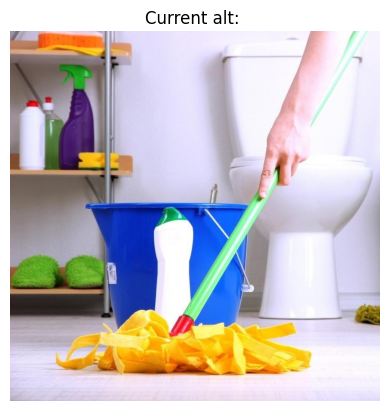

Parent <a> or <button> found:  True
Parent tag:  <a href="https://www.bnbbosses.com/Questions-for-Cleaners" rel="noopener" target="_blank">
<img alt="" class="feature__image" kjb-settings-id="sections_1575400143733_blocks_1575400143733_1_settings_image" src="https://kajabi-storefronts-production.kajabi-cdn.com/kajabi-storefronts-production/themes/3479602/settings_images/6UVqROJTAqAZGqgXD4bT_xZYphsSTQHzEOcbNmVjk_clean.jpg"/>
</a>
Data saved


In [7]:
import requests
from bs4 import BeautifulSoup
import json
from IPython.display import clear_output
import os
from selenium import webdriver

i_website = 1
# Load the progress
try:
    with open("progress.txt", "r") as f:
        i_website = int(f.readline())
except FileNotFoundError:
    pass


for i in range(i_website, len(websites)):
    website_info = {}
    try:
        # Open the URL in a new tab for reference while labelling
        driver = webdriver.Chrome()
        driver.get(websites[i])# Get the page source after interactions
        page = driver.page_source
        # Skip website?
        skip = input("Skip website? (input anything to skip): ")
        if skip == 'q':
            # Save the progress
            with open("progress.txt", "w") as f:
                f.write(str(i_website))
            driver.quit()
            break
        if skip:
            i_website += 1
            continue

        # Initialize the list to store the image data
        images_info = []
        # Get the HTML content of the page
        # page = requests.get(websites[i])

        # Parse the HTML content
        soup = BeautifulSoup(page, "html.parser")# Extract data using Beautiful Soup methods

        # Get all text in the page
        text = soup.get_text()
        website_info['text'] = text

        # Create a folder in ./images/ with the name of the website
        os.makedirs(f"./images/{websites[i].split('//')[1].replace('/', '-')}", exist_ok=True)

        # Find all 'img' tags
        images = soup.find_all("img")
        # Remove duplicates
        images = set(images)


        i_image = 1
        for image in images:
            try:
                # GET RELEVANT DATA OF THE IMAGE
                # Clear the output before displaying the next image to avoid an overly big notebook size
                clear_output(wait=True)
                
                print(f"Image {i_image} of {len(images)}, website {i_website} of {len(websites)}")

                # The 'src' attribute of the image
                image_url = image["src"]
                print("Image URL: ", image_url)
                # Relative path handling
                if not image_url.startswith(('http://', 'https://')):
                    image_url = urljoin(websites[i], image_url)

                # The 'alt' attribute of the image
                image_alt = image.get("alt", "No alt attribute")  # Use a default value if 'alt' is missing

                # The image file name
                file_name = f"./images/{websites[i].split('//')[1].replace('/', '-')}/image_{i_image}.jpg"

                # LABELLING (ROLE AND ALT TEXT)
                # Label the image manually
                data = label_image(image_url, image_alt, file_name)
                if data == 'q':
                    # Save the progress
                    with open("progress.txt", "w") as f:
                        f.write(str(i_website))
                        f.write("\n")
                        f.write(str(i_image))
                    break
                if data is None:
                    continue

                # OTHER IMAGE ATTRIBUTES
                image_attrs = image.attrs

                # Find out if image has <a> parent or <button> parent, potentially indicating a functional image
                a_button_parent_found = False
                # Loop up to 3 levels up the hierarchy
                current_tag = image
                a_button_parent = None
                for _ in range(3):
                    # Try to find a parent <a> tag or <button> tag
                    a_button_parent = current_tag.find_parent(["a", "button"])
                    if a_button_parent:
                        # If an <a> or <button> parent is found, set the flag to True and break the loop
                        a_button_parent_found = True
                        break
                    else:
                        # If not found, move up to the next parent
                        current_tag = current_tag.parent
                        # If the current tag is None (top of the tree), break the loop
                        if current_tag is None:
                            break
                print("Parent <a> or <button> found: ", a_button_parent_found)
                print("Parent tag: ", a_button_parent)

                # NEAREST TEXT FROM IMAGE FOR TEXT CONTEXT
                previous_text = image.find_previous(["p", "h1", "h2", "h3", "h4", "h5", "h6"])
                next_text = image.find_next(["p", "h1", "h2", "h3", "h4", "h5", "h6"])

                # Write the data (image and labels) to a file
                images_info.append({
                    "src": image_url,
                    "file_name": file_name,
                    "role": data['role'],
                    "alt": data['alt'],
                    "attrs": image_attrs,
                    "a_button_parent": str(a_button_parent),
                    "previous_text": previous_text.text if previous_text else "",
                    "next_text": next_text.text if next_text else "",
                })
                print("Data saved")
                
            except KeyError:
                # Put to log file
                with open("error.log", "a") as f:
                    f.write(f"Error at image {i_image} of website {i_website}: Key error")
                    if image_url:
                        f.write(f"Image URL: {image_url}\n")
            except requests.exceptions.MissingSchema:
                # Put to log file
                with open("error.log", "a") as f:
                    f.write(f"Error at image {i_image} of website {i_website}: Missing schema\n")
                    if image_url:
                        f.write(f"Image URL: {image_url}\n")
            except Exception as e:
                print(f"An error occurred: {e}")
                # Put to log file
                with open("error.log", "a") as f:
                    f.write(f"Error at image {i_image} of website {i_website}: {e}\n")
                    if image_url:
                        f.write(f"Image URL: {image_url}\n")

            i_image += 1

        website_info['images'] = images_info
        # Step 4: Write the list to a file in JSON format
        with open(f"./output/{websites[i].split('//')[1].replace('/', '-')}.json", "w") as f:
            json.dump(website_info, f, indent=4)

        i_website += 1

    except Exception as e:
        print(f"An error occurred: {e}")
        i_website += 1
        # Put to log file
        with open("error.log", "a") as f:
            f.write(f"Error at website {i_website}: {e}\n")

# Create the AI

In [2]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

# CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
# print("CUDA version:", CUDA_version)

# if CUDA_version == "10.0":
#     torch_version_suffix = "+cu100"
# elif CUDA_version == "10.1":
#     torch_version_suffix = "+cu101"
# elif CUDA_version == "10.2":
#     torch_version_suffix = ""
# else:
#     torch_version_suffix = "+cu110"

%pip install torch==1.7.1+cpu torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html

import numpy as np
import torch

print("Torch version:", torch.__version__)

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
DEPRECATION: The HTML index page being used (https://download.pytorch.org/whl/torch_stable.html) is not a proper HTML 5 document. This is in violation of PEP 503 which requires these pages to be well-formed HTML 5 documents. Please reach out to the owners of this index page, and ask them to update this index page to a valid HTML 5 document. pip 22.2 will enforce this behaviour change. Discussion can be found at https://github.com/pypa/pip/issues/10825
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.1

In [6]:
%pip install gdown ftfy regex

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 KB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

clip_dir = Path(".").absolute() / "CLIP"
sys.path.append(str(clip_dir))
print(f"CLIP dir is: {clip_dir}")

import clip

fatal: destination path 'CLIP' already exists and is not an empty directory.
CLIP dir is: /home/felinejtd/projects/itb/ta/image-alt-text-ai/CLIP


In [9]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

Model dir: /home/felinejtd/.cache/clip
